In [ ]:
import cv2
import numpy as np
import os

# Directories
image_dir = "/content/images"
txt_dir = "/content/txt"
mask_dir = "/content/masks"

# Ensure mask directory exists
os.makedirs(mask_dir, exist_ok=True)

image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

for img_name in image_filenames:
    img_path = os.path.join(image_dir, img_name)
    txt_path = os.path.join(txt_dir, img_name.replace(".jpg", ".txt"))
    mask_path = os.path.join(mask_dir, img_name.replace(".jpg", ".png"))

    image = cv2.imread(img_path)
    if image is None:
        print(f"❌ ERROR: Could not read {img_path}")
        continue

    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    if os.path.exists(txt_path):
        with open(txt_path, "r") as file:
            for line in file:
                values = line.split()
                if len(values) != 5:
                    print(f"⚠️ Skipping invalid annotation in {txt_path}: {line.strip()}")
                    continue

                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                x1 = int((x_center - bbox_width / 2) * width)
                y1 = int((y_center - bbox_height / 2) * height)
                x2 = int((x_center + bbox_width / 2) * width)
                y2 = int((y_center + bbox_height / 2) * height)

                x1, y1, x2, y2 = max(0, x1), max(0, y1), min(width - 1, x2), min(height - 1, y2)

                print(f"📌 Drawing box on {img_name}: ({x1}, {y1}) -> ({x2}, {y2})")

                cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

        cv2.imwrite(mask_path, mask)
        print(f"✅ Mask saved: {mask_path}")

    else:
        print(f"⚠️ No annotation file for {img_name}")


📌 Drawing box on cocklebur_068.jpg: (1556, 756) -> (2438, 1764)
📌 Drawing box on cocklebur_068.jpg: (1335, 1562) -> (1836, 2662)
📌 Drawing box on cocklebur_068.jpg: (1905, 1646) -> (2431, 2226)
📌 Drawing box on cocklebur_068.jpg: (2472, 1633) -> (2951, 2142)
📌 Drawing box on cocklebur_068.jpg: (1880, 2129) -> (2472, 2973)
✅ Mask saved: /content/masks/cocklebur_068.png
📌 Drawing box on cocklebur_081.jpg: (945, 768) -> (1575, 1104)
📌 Drawing box on cocklebur_081.jpg: (576, 966) -> (1206, 1444)
📌 Drawing box on cocklebur_081.jpg: (1162, 1264) -> (1619, 1696)
📌 Drawing box on cocklebur_081.jpg: (1700, 961) -> (2151, 1512)
📌 Drawing box on cocklebur_081.jpg: (1118, 1722) -> (1612, 2104)
📌 Drawing box on cocklebur_081.jpg: (611, 1646) -> (1036, 2032)
📌 Drawing box on cocklebur_081.jpg: (806, 2020) -> (1461, 2511)
✅ Mask saved: /content/masks/cocklebur_081.png
📌 Drawing box on cocklebur_143.jpg: (429, 1343) -> (911, 1860)
📌 Drawing box on cocklebur_143.jpg: (901, 1524) -> (1502, 2133)
📌 Drawi

In [ ]:
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the dataset class
class AgricultureSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get file paths
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".jpg", ".png"))

        # Read images and masks
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        # Apply transformations if specified (using albumentations)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Convert mask to tensor (LongTensor for segmentation)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

# Define Albumentations transformations for image and mask
transform = A.Compose([
    A.Resize(256, 256),                      # Resize both image and mask
    A.RandomCrop(width=256, height=256),     # Randomly crop the image
    A.HorizontalFlip(p=0.5),                 # Augment with random horizontal flip
    A.RandomRotate90(p=0.5),                 # Randomly rotate image and mask
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    ToTensorV2(),                            # Convert image to tensor
])

# Define data directories
image_dir = "/content/images"
mask_dir = "/content/masks"

# Create dataset and dataloaders
dataset = AgricultureSegmentationDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check the dataset and dataloader
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")
    break  # Just check the first batch


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-2-817f63113be4>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Image batch shape: torch.Size([4, 3, 256, 256]), Mask batch shape: torch.Size([4, 256, 256])


In [ ]:
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# Define the dataset class
class AgricultureSegmentationDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir, transform=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get file paths
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".jpg", ".png"))

        # Read images and masks
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        # Normalize mask (ensure it has values between 0 and num_classes-1)
        mask = mask.astype(np.uint8)  # Convert to uint8
        mask[mask > 3] = 3  # Assume 4 disease classes (0-3), limit values to this range

        # Apply transformations if specified (using albumentations)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Fix: Ensure mask is a tensor
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()

        return image, mask

# Define Albumentations transformations for image and mask
transform = A.Compose([
    A.Resize(256, 256),                      # Resize both image and mask
    A.RandomCrop(width=256, height=256),     # Randomly crop the image
    A.HorizontalFlip(p=0.5),                 # Augment with random horizontal flip
    A.RandomRotate90(p=0.5),                 # Randomly rotate image and mask
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    ToTensorV2(),                            # Convert image to tensor
])

# Define data directories
image_dir = "/content/images"
mask_dir = "/content/masks"

# List all image files
all_image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Split into training and testing (80% train, 20% test)
train_files, test_files = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

# Create dataset and dataloaders
train_dataset = AgricultureSegmentationDataset(train_files, image_dir, mask_dir, transform=transform)
test_dataset = AgricultureSegmentationDataset(test_files, image_dir, mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Check the dataset and dataloader
for images, masks in train_loader:
    print(f"Train Batch - Image shape: {images.shape}, Mask shape: {masks.shape}")
    break  # Just check the first batch

for images, masks in test_loader:
    print(f"Test Batch - Image shape: {images.shape}, Mask shape: {masks.shape}")
    break  # Just check the first batch


Train Batch - Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 256, 256])
Test Batch - Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 256, 256])


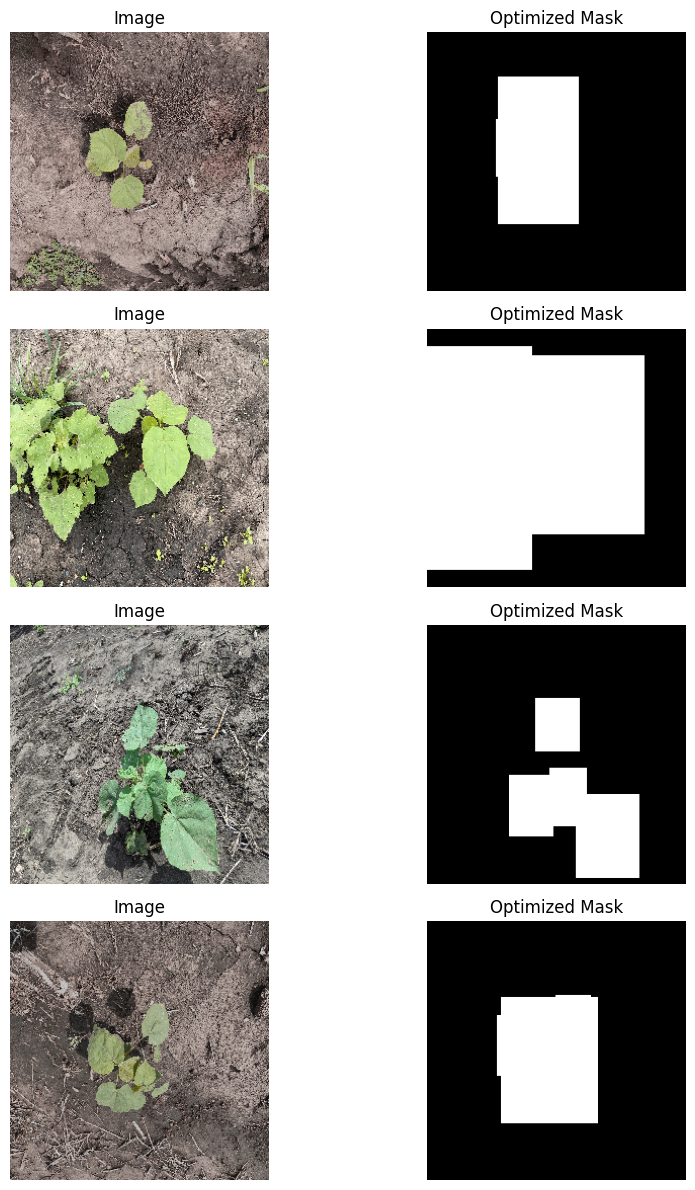

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to check mask values and ensure correct formatting
def optimize_masks(masks):
    # Convert masks to binary (assuming single-channel segmentation)
    masks = masks.float()  # Convert to float if not already
    masks = (masks > 0).long()  # Convert to binary format (0 and 1)

    return masks

# Check and visualize the optimized masks
def visualize_masks(dataloader, num_samples=4):
    images, masks = next(iter(dataloader))
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert tensor to numpy for plotting
    masks = optimize_masks(masks.cpu())  # Optimize masks

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i], cmap="gray")
        axes[i, 1].set_title("Optimized Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Run optimization and display results
visualize_masks(train_loader)


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models

class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if image and mask are loaded correctly
        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask for index {idx}")

        # Ensure the same shape for image and mask
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Convert mask to long tensor (required for cross-entropy loss)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

# Define transformations with Resize to ensure image and mask have same size
transform = A.Compose([
    A.Resize(256, 256),  # Resize both image and mask to the same size
    A.RandomCrop(width=256, height=256),  # Apply random cropping if needed
    A.RandomRotate90(p=0.5),  # Randomly rotate images and masks
    A.HorizontalFlip(p=0.5),  # Flip images and masks horizontally
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize image
    ToTensorV2()  # Convert image to tensor
], additional_targets={'mask': 'mask'}, is_check_shapes=False)  # Disable shape check

# Dataset paths
images_dir = '/content/images'
masks_dir = '/content/masks'

# Create dataset and dataloader
dataset = CustomDataset(images_dir, masks_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check the dataset and dataloader
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")
    break  # Just check the first batch


<ipython-input-5-77d1e01ca6a9>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Image batch shape: torch.Size([4, 3, 256, 256]), Mask batch shape: torch.Size([4, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DeepLabV3+ with ResNet-50
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1))  # For binary classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()

    loss_history, acc_history, iou_history, dice_history = [], [], [], []

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct_pixels = 0
        total_pixels = 0
        intersection = 0
        union = 0
        dice_total = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            inter = ((preds == 1) & (masks == 1)).sum().item()
            union_ = ((preds == 1) | (masks == 1)).sum().item()
            dice = (2 * inter) / (preds.eq(1).sum().item() + masks.eq(1).sum().item() + 1e-6)

            intersection += inter
            union += union_
            dice_total += dice

        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct_pixels / total_pixels
        iou = intersection / (union + 1e-6)
        dice_score = dice_total / len(train_loader)

        loss_history.append(avg_loss)
        acc_history.append(accuracy)
        iou_history.append(iou)
        dice_history.append(dice_score)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | IoU: {iou:.4f} | Dice: {dice_score:.4f}")

    return model, loss_history, acc_history, iou_history, dice_history

# Train
trained_model, loss_hist, acc_hist, iou_hist, dice_hist = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=6)


Epoch 1/6 | Loss: 0.4624 | Acc: 0.8264 | IoU: 0.4879 | Dice: 0.6600
Epoch 2/6 | Loss: 0.2971 | Acc: 0.9040 | IoU: 0.6163 | Dice: 0.7636
Epoch 3/6 | Loss: 0.2263 | Acc: 0.9236 | IoU: 0.6911 | Dice: 0.8123
Epoch 4/6 | Loss: 0.1986 | Acc: 0.9324 | IoU: 0.7218 | Dice: 0.8366
Epoch 5/6 | Loss: 0.1634 | Acc: 0.9446 | IoU: 0.7671 | Dice: 0.8651
Epoch 6/6 | Loss: 0.1350 | Acc: 0.9557 | IoU: 0.8096 | Dice: 0.8885


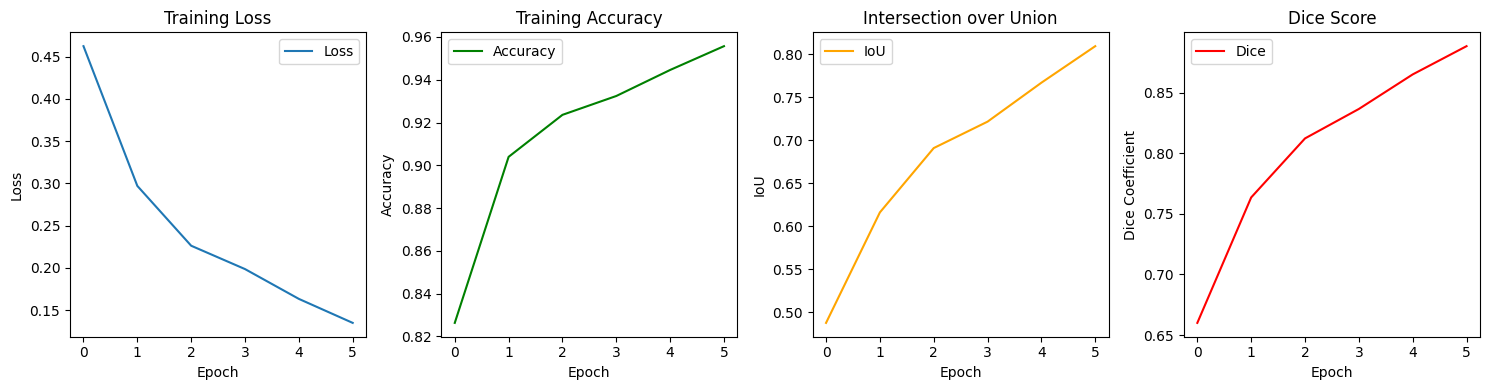

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(loss_hist, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(acc_hist, label="Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(iou_hist, label="IoU", color='orange')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Intersection over Union")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(dice_hist, label="Dice", color='red')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice Score")
plt.legend()

plt.tight_layout()
plt.show()


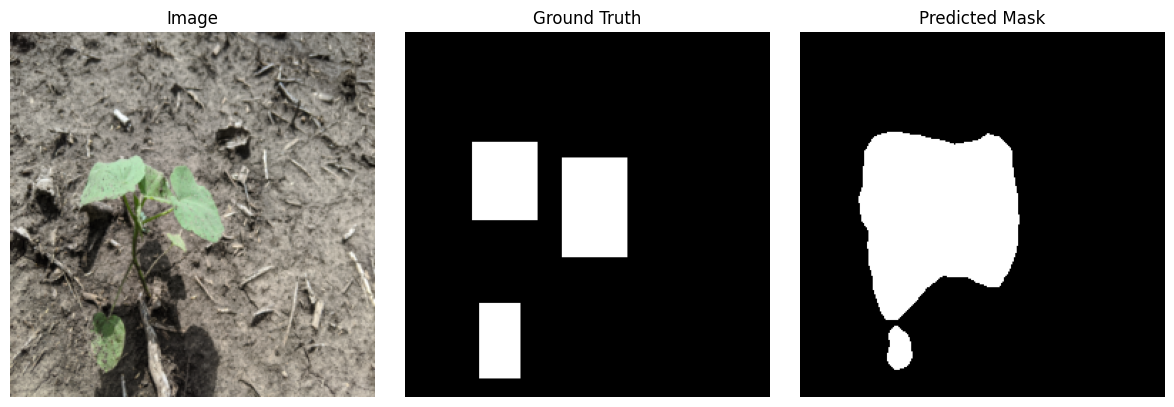

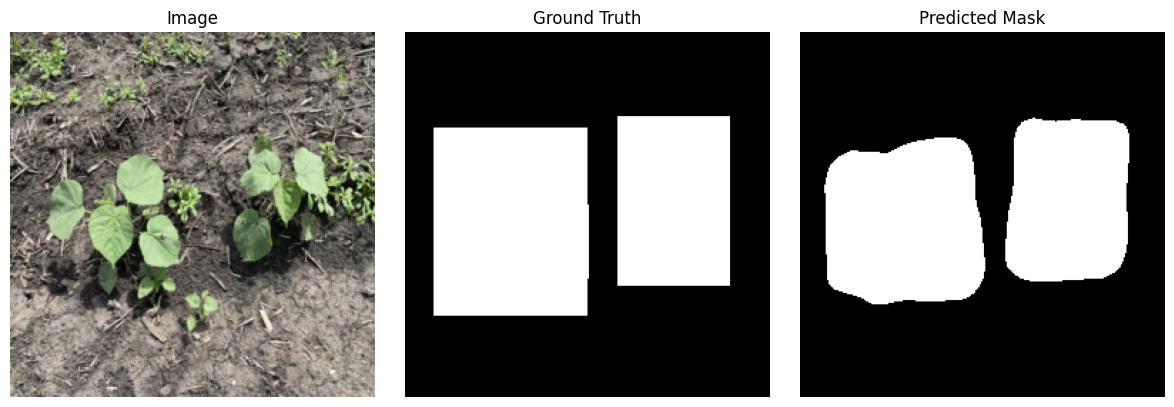

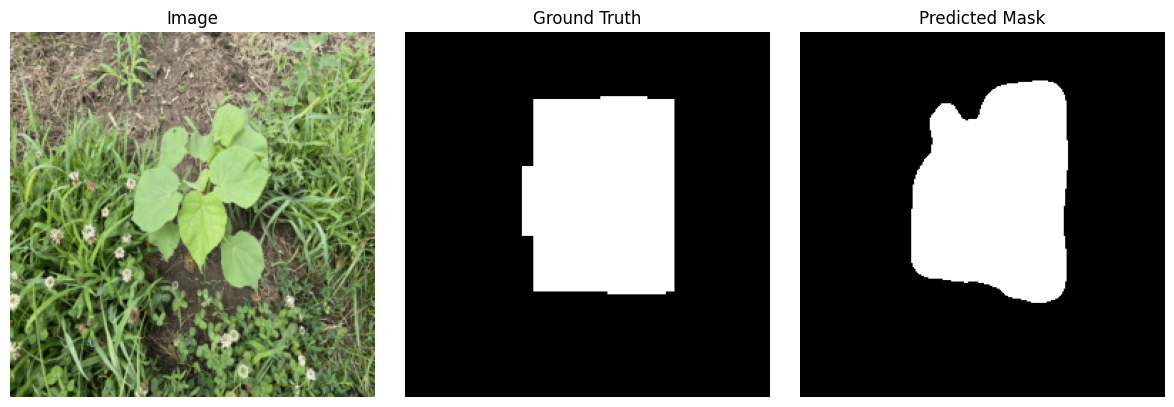

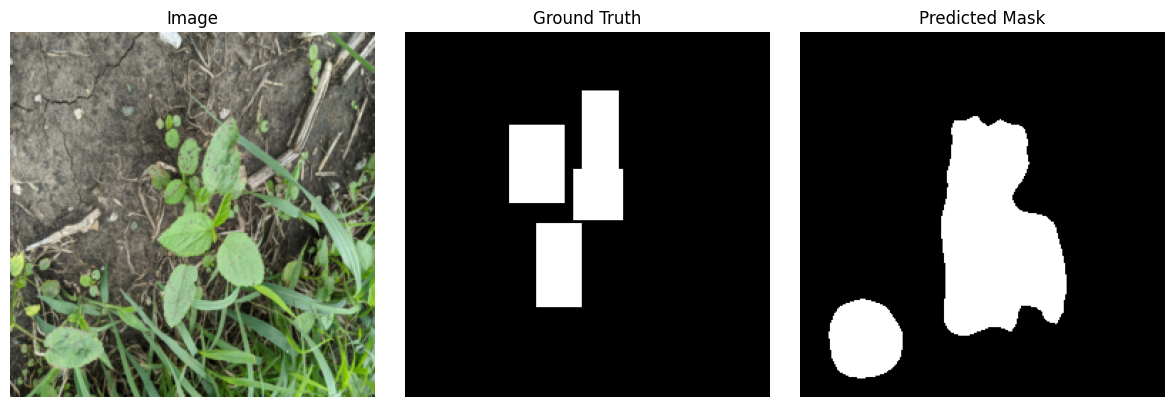

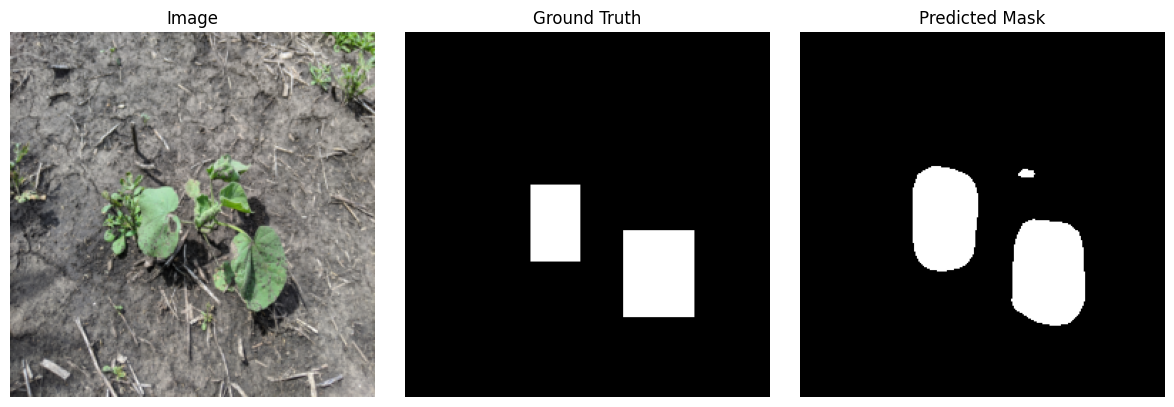

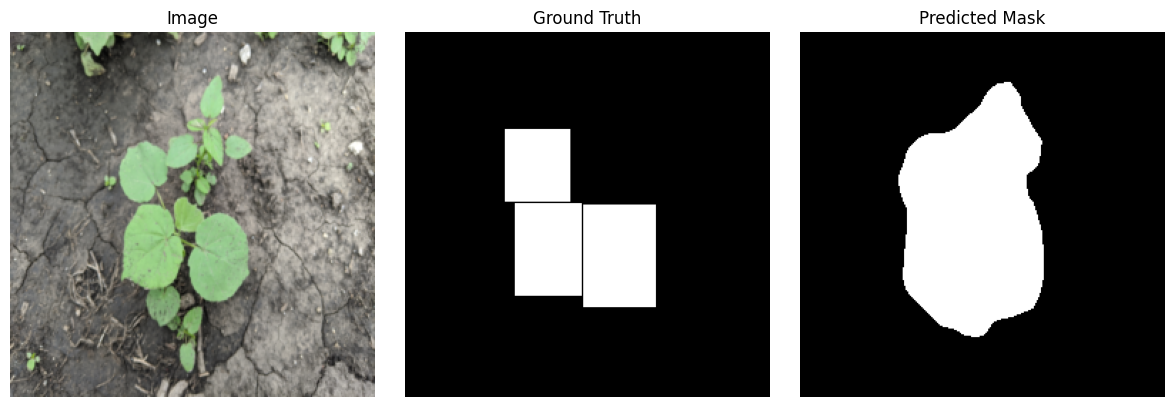

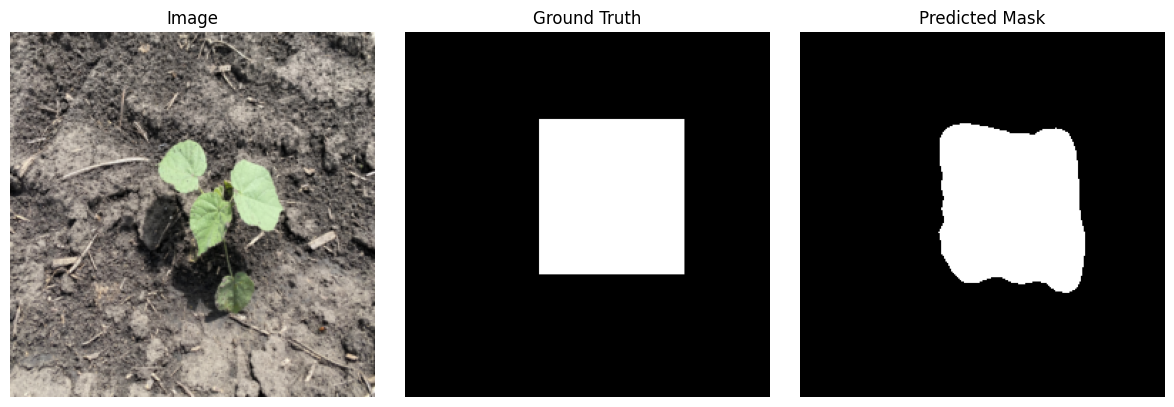

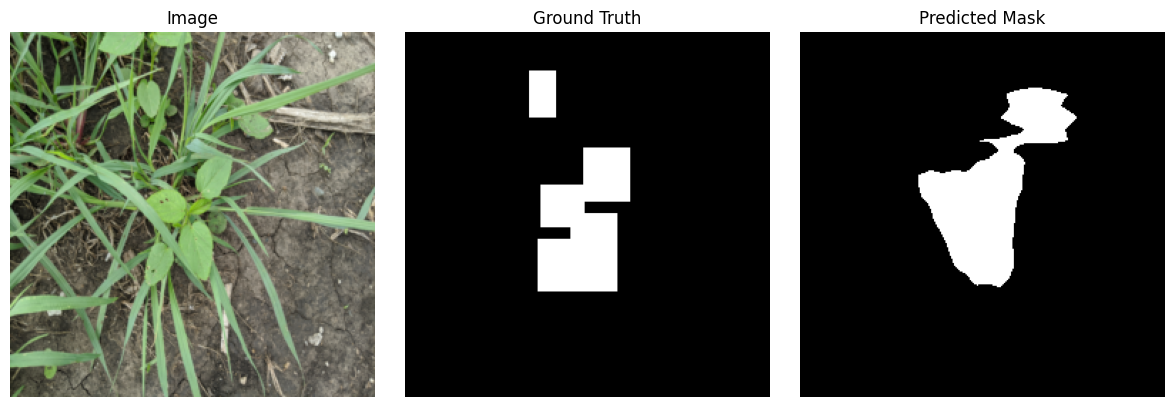

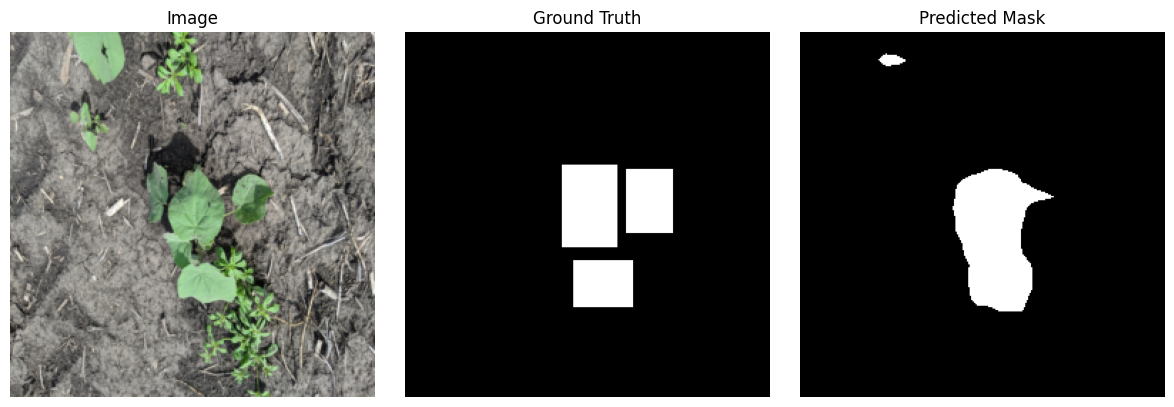

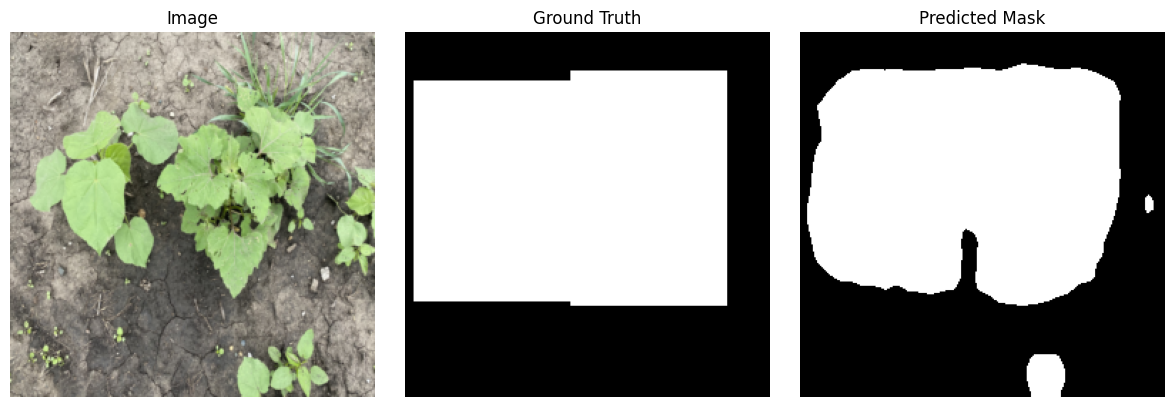

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1).cpu()

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return

                image_np = images[i].cpu().permute(1, 2, 0).numpy()
                mask_gt = masks[i].cpu().numpy()
                mask_pred = preds[i].numpy()

                # Plotting
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image_np)
                plt.title("Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_gt, cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(mask_pred, cmap="gray")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                images_shown += 1
visualize_predictions(trained_model, val_loader, num_images=10)


In [ ]:
# Save the trained model state_dict and training metrics
torch.save(trained_model.state_dict(), "deeplabv3_resnet50_trained_model.pth")


training_metrics = {
    'loss': loss_history,
    'accuracy': acc_history,
    'iou': iou_history,
    'dice': dice_history
}
torch.save(training_metrics, "deeplabv3_resnet50_metrics.pt")


In [ ]:
from google.colab import files

# weights
files.download("deeplabv3_resnet50_trained_model.pth")

# metrics
files.download("deeplabv3_resnet50_metrics.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>